In [1]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
transactions_im = pd.read_csv('transactions_cluster4.csv', header=0)

In [3]:
transactions = transactions_im.fillna(0)

In [4]:
transactions['date'] = pd.to_datetime(transactions['date'], format = '%Y-%m-%d')
transactions = transactions.set_index('date')

In [5]:
ts = transactions.mean(axis=1)
ts.head()

date
2017-04-20    740.250000
2017-04-21    785.500000
2017-04-22    873.833333
2017-04-23    822.083333
2017-04-24    731.166667
dtype: float64

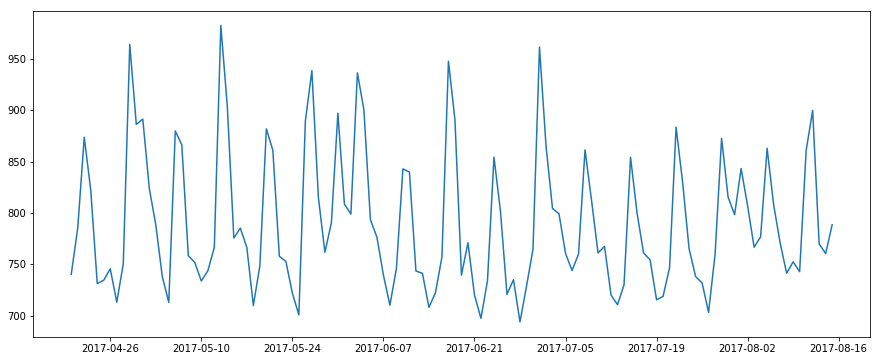

In [6]:
plt.plot(ts.index.to_pydatetime(), ts.values)

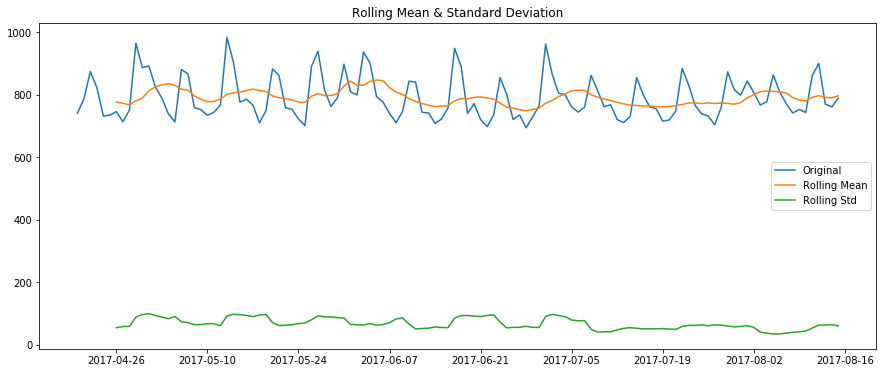

In [9]:
rolmean = ts.rolling(window=7).mean()
rolstd = ts.rolling(window=7).std()

#Plot rolling statistics:
orig = plt.plot(ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [10]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=10)
    rolstd = pd.rolling_std(timeseries, window=10)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()
  """


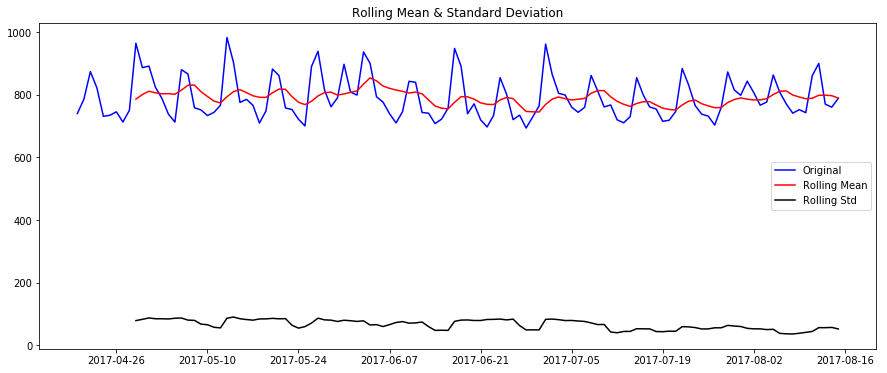

Results of Dickey-Fuller Test:
Test Statistic                  -1.882945
p-value                          0.340126
#Lags Used                      13.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


In [11]:
test_stationarity(ts)

In [12]:
ts_log = np.log(ts)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()
  """


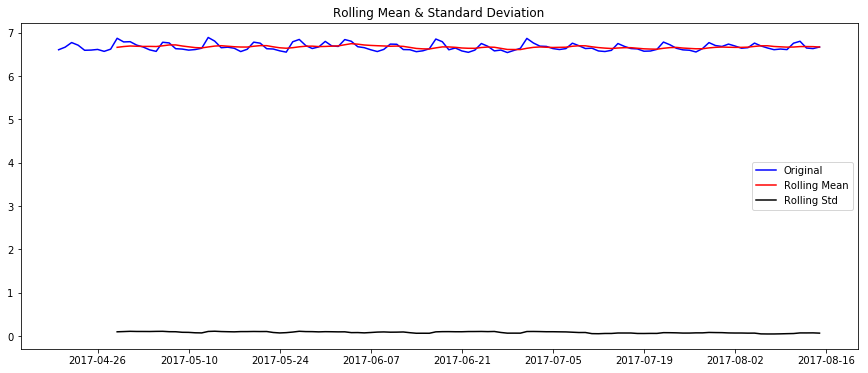

Results of Dickey-Fuller Test:
Test Statistic                  -1.905755
p-value                          0.329359
#Lags Used                      13.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


In [13]:
test_stationarity(ts_log)

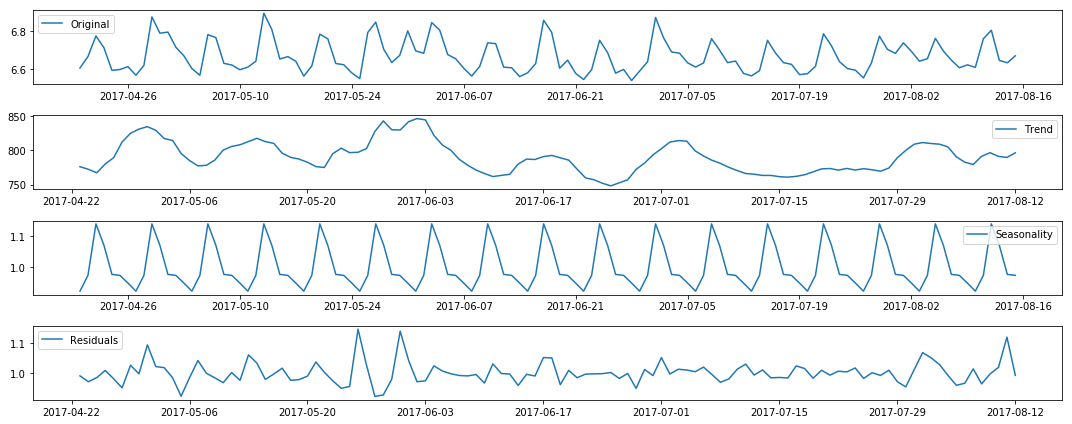

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts,model='multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

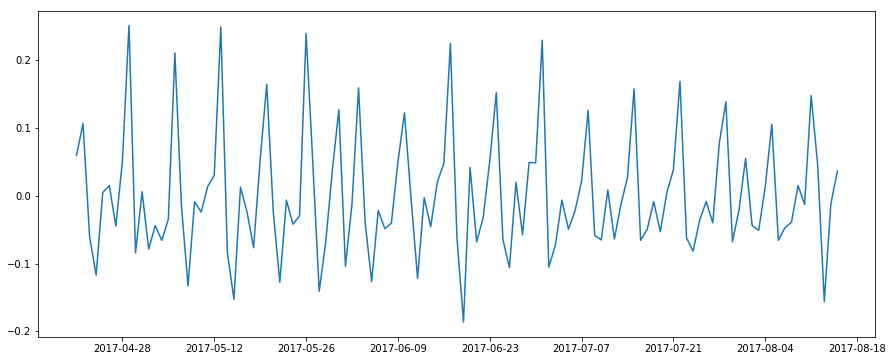

In [15]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff.index.to_pydatetime(), ts_log_diff.values)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()
  """


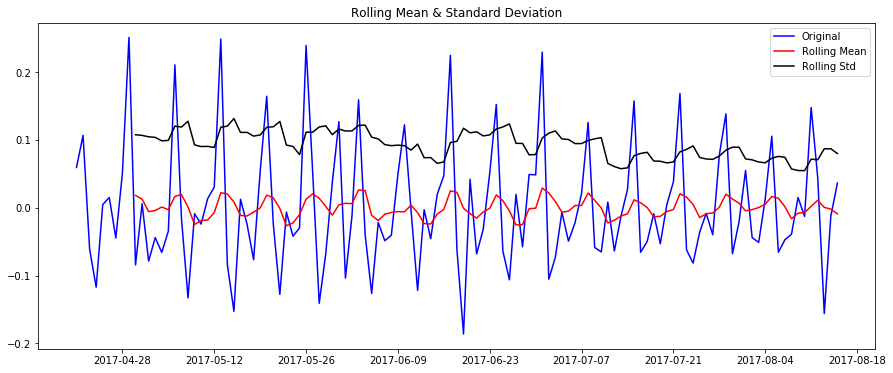

Results of Dickey-Fuller Test:
Test Statistic                  -4.881533
p-value                          0.000038
#Lags Used                      13.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


In [16]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

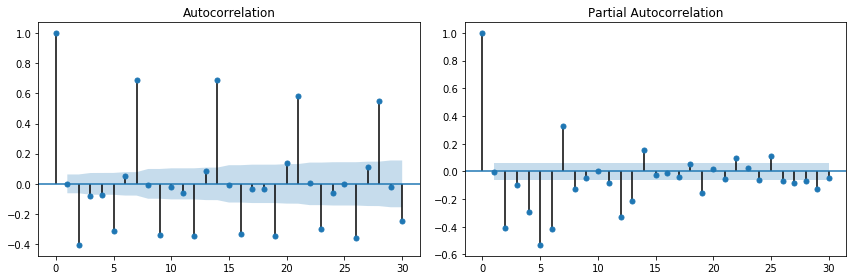

In [17]:
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(ts_log_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(ts_log_diff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

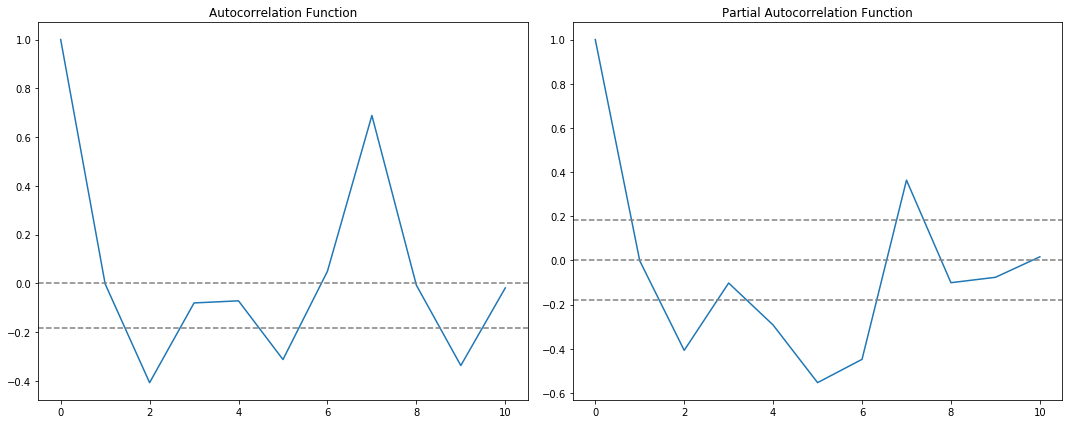

In [18]:
#ACF and PACF plots

lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [37]:
model = ARIMA(ts_log, order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,'RSS: 0.5803')

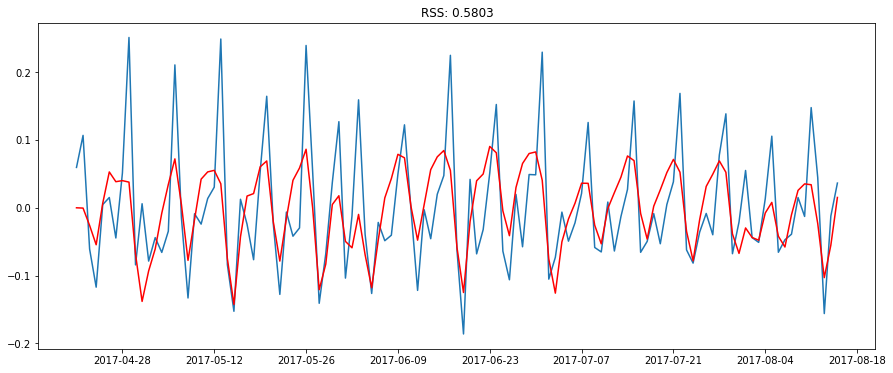

In [38]:
plt.plot(ts_log_diff.index.to_pydatetime(), ts_log_diff.values)
plt.plot(ts_log_diff.index.to_pydatetime(), results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [42]:
results_ARIMA.fittedvalues

date
2017-04-21   -0.000190
2017-04-22   -0.000617
2017-04-23   -0.026214
2017-04-24   -0.054667
2017-04-25    0.006535
2017-04-26    0.052669
2017-04-27    0.038293
2017-04-28    0.039863
2017-04-29    0.037668
2017-04-30   -0.068622
2017-05-01   -0.138182
2017-05-02   -0.093206
2017-05-03   -0.060821
2017-05-04   -0.008133
2017-05-05    0.034307
2017-05-06    0.071914
2017-05-07    0.004282
2017-05-08   -0.077679
2017-05-09   -0.017310
2017-05-10    0.042021
2017-05-11    0.052720
2017-05-12    0.055015
2017-05-13    0.035199
2017-05-14   -0.075076
2017-05-15   -0.142691
2017-05-16   -0.042859
2017-05-17    0.017120
2017-05-18    0.020770
2017-05-19    0.060207
2017-05-20    0.068856
                ...   
2017-07-17   -0.046282
2017-07-18    0.002173
2017-07-19    0.026308
2017-07-20    0.051745
2017-07-21    0.071140
2017-07-22    0.052293
2017-07-23   -0.034770
2017-07-24   -0.078385
2017-07-25   -0.017683
2017-07-26    0.031333
2017-07-27    0.049361
2017-07-28    0.068968
2017-0

In [23]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  117
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 144.674
Method:                       css-mle   S.D. of innovations              0.069
Date:                Wed, 13 Dec 2017   AIC                           -279.347
Time:                        13:44:01   BIC                           -265.536
Sample:                    04-21-2017   HQIC                          -273.740
                         - 08-15-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.857      0.393      -0.001       0.000
ar.L1.D.y      0.5709      0.084      6.805      0.000       0.406       0.735
ar.L2.D.y     -0.4148      0.083     -4.985      0.0

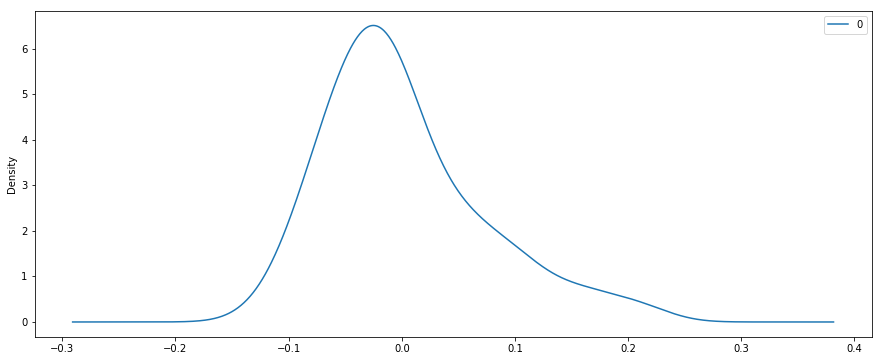

In [24]:
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')

In [25]:
print(residuals.describe())

                0
count  117.000000
mean     0.001720
std      0.070705
min     -0.122783
25%     -0.047987
50%     -0.010542
75%      0.042822
max      0.213430


In [26]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
2017-04-21   -0.000190
2017-04-22   -0.000617
2017-04-23   -0.026214
2017-04-24   -0.054667
2017-04-25    0.006535
dtype: float64


In [27]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)

In [28]:
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

In [29]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5,1,'RMSE: 186.9574')

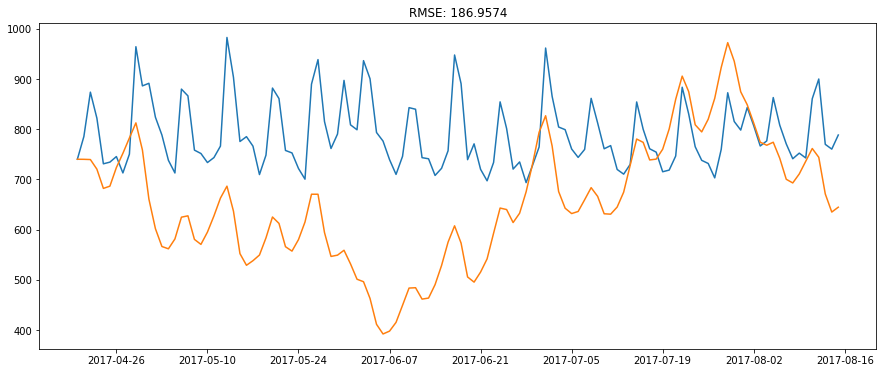

In [30]:
plt.plot(ts.index.to_pydatetime(), ts.values)
plt.plot(ts.index.to_pydatetime(), predictions_ARIMA.values)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [31]:
expected=list(ts)

In [32]:
bias=[expected[i]-predictions_ARIMA_diff[i] for i in range(len(predictions_ARIMA_diff))]

In [33]:
mean_forcast_error=sum(bias)/len(bias)
print('Mean forcast error: %f' % mean_forcast_error)

Mean forcast error: 790.403602


In [34]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(expected[1:], predictions_ARIMA_diff)
print('MAE: %f' % mae)

MAE: 790.815995
